In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [18]:
import os
import warnings
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import visualkeras

from keras import Sequential, Model
from keras.layers import Dense, Conv2D, Reshape, UpSampling2D, \
    BatchNormalization, Activation, Input, LeakyReLU, ZeroPadding2D, Dropout, Flatten, Conv2DTranspose
from keras.optimizers import Adam
from keras.datasets import mnist
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable TF Warnings
tf.get_logger().setLevel('INFO')
warnings.filterwarnings("ignore")
seed=np.random.seed(69)
sns.set(style='darkgrid', palette='deep')

In [3]:
df = pd.read_csv('emnist-letters-train.csv')

In [4]:
df = pd.read_csv('emnist-letters-train.csv')
y1 = np.array(df.iloc[:,0].values)
x1 = np.array(df.iloc[:,1:].values)
x1 = np.array([np.rot90(np.flipud(sample.reshape(28, 28)), k=3) for sample in x1])
print(y1.shape)
print(x1.shape)

(99039,)
(99039, 28, 28)


In [5]:
pd.Series(y1).value_counts()

-1     10240
 25     3453
 11     3438
 5      3437
 24     3437
 20     3436
 17     3435
 16     3430
 9      3428
 26     3427
 8      3424
 22     3422
 23     3422
 18     3419
 21     3419
 3      3419
 12     3415
 15     3408
 10     3402
 13     3402
 4      3398
 1      3396
 2      3396
 6      3394
 19     3392
 7      3385
 14     3365
Name: count, dtype: int64

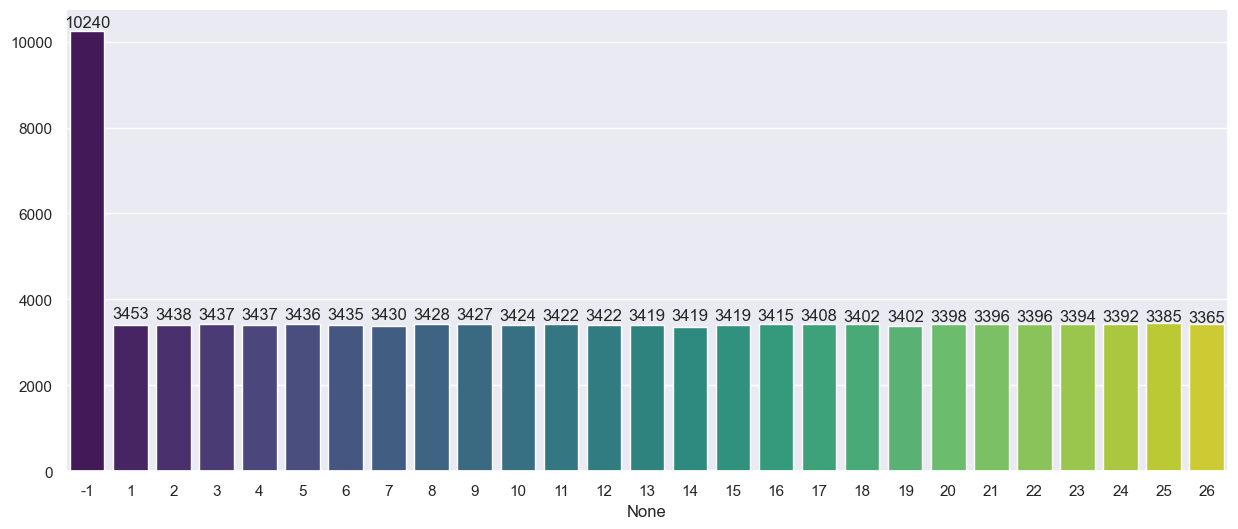

In [6]:
# Bar plot of each letter
plt.figure(figsize=(15, 6))
values = pd.Series(y1).value_counts()
sns.barplot(x=values.index, y=values.values, palette='viridis')
# Add value on top of the bar
for i, value in enumerate(values.values):
    plt.text(i, value+100, f'{value}', ha='center')

In [7]:
number_to_letter = {}
for i in range(1, 27):
    number_to_letter[i] = chr(ord('a') + i - 1)
number_to_letter[-1] = 'nothing'

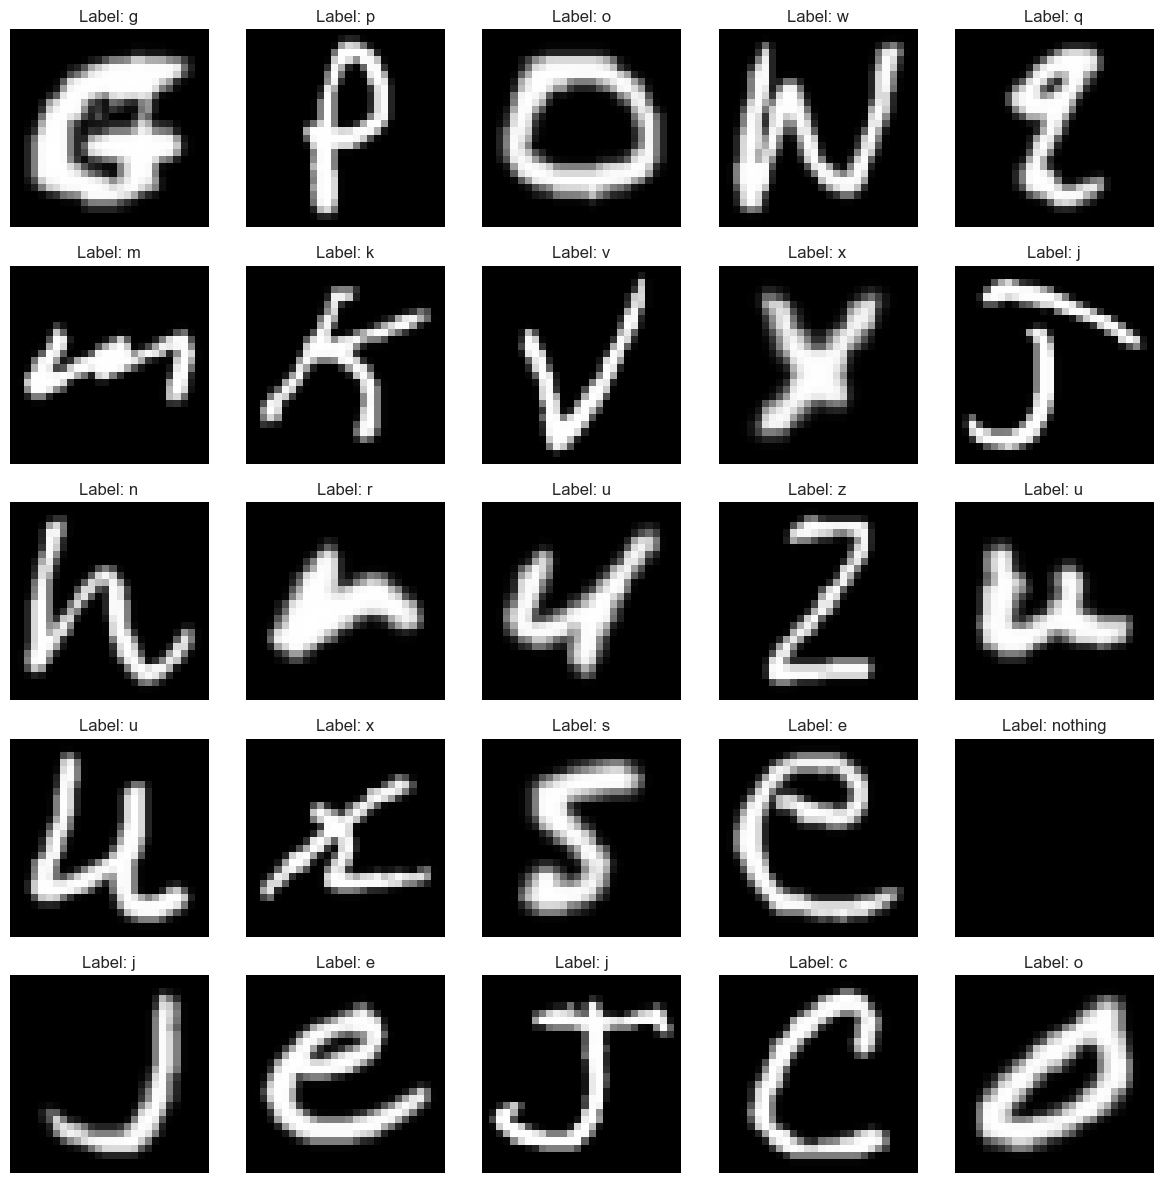

In [8]:
import matplotlib.pyplot as plt 
fig,axes = plt.subplots(5,5,figsize=(12,12))
for i,ax in enumerate(axes.flat):
    ax.set_title(f'Label: {number_to_letter[y1[i]]}')
    ax.imshow(x1[i], cmap='gray')
    ax.axis('off')  # Turn off the axis


plt.tight_layout()

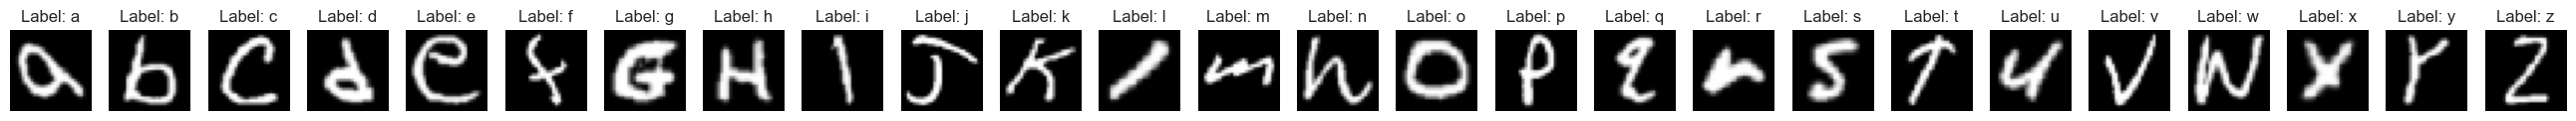

In [9]:
# SHow an image from each classes
fig,axes = plt.subplots(1,26,figsize=(26,26))
for i,ax in enumerate(axes.flat):
    ax.set_title(f'Label: {number_to_letter[i+1]}')
    ax.imshow(x1[y1==i+1][0], cmap='gray')
    ax.axis('off')  # Turn off the axis

plt.tight_layout()

In [10]:
np.random.seed(69)

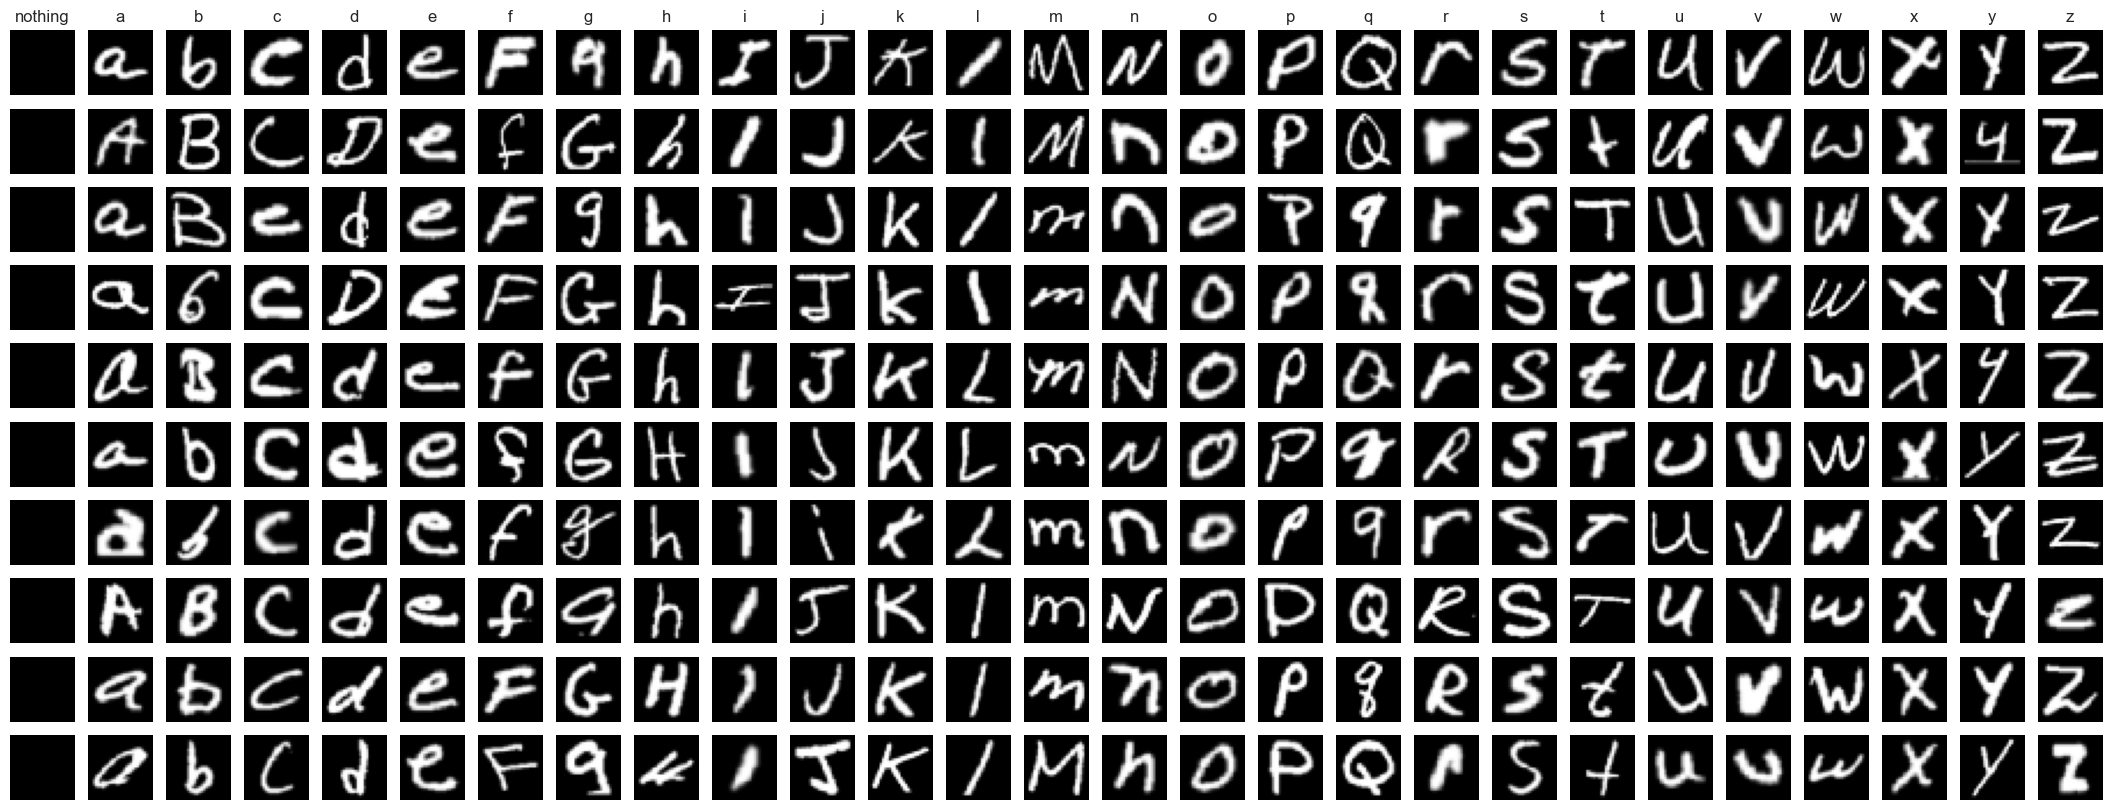

In [14]:
# Show 5 image from each classes
fig,axes = plt.subplots(10,27,figsize=(27,10))
for i,ax in enumerate(axes.flat):
    if i%27 == 0:
        ax.imshow(x1[y1 == -1][np.random.choice(len(x1[y1 == -1]))], cmap='gray')
    else:
        ax.imshow(x1[y1==i%27][np.random.choice(len(x1[y1 == i%27]))], cmap='gray')
    ax.axis('off')  # Turn off the axis


# Add title to first row
axes[0,0].set_title(f'{number_to_letter[-1]}')
for i in range(1,27):
    axes[0,i].set_title(f'{number_to_letter[i%27]}')

### <u>Observation</u>

Most classes sames to have

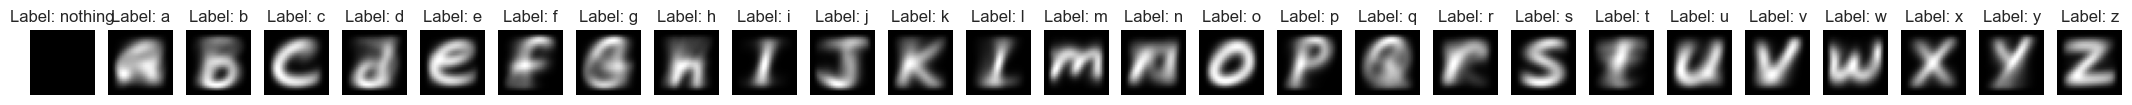

In [ ]:
# Get average image of each classes
average_images = []
for i in range(27):
    if i == 0:
        i = -1
    average_images.append(np.mean(x1[y1==i], axis=0))

# Show average image of each classes
fig,axes = plt.subplots(1,27,figsize=(27,27))   
for i,ax in enumerate(axes.flat):
    ax.imshow(average_images[i], cmap='gray')
    ax.imshow(average_images[i], cmap='gray')
    ax.axis('off')  # Turn off the axis
    if i == 0:
        i = -1
    ax.set_title(f'Label: {number_to_letter[i]}')

In [22]:
class DCGAN():
    
    # this is the function to build the generator neural network
    def build_generator(self):
        model = Sequential(name='Generator')
        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim)) # connect the input to dense layer
        model.add(Reshape((7, 7, 128)))
        # upsample from 7*7 to 14*14
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        # upsample to 28x28
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(self.channels, kernel_size=7, padding="same", activation='sigmoid'))
        model.summary()
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)  # the keras Model class groups layers into an object with training and inference features
    
    def build_discriminator(self):
        model = Sequential(name='Discriminator')
        model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)

    def __init__(self, rows, cols, channels, z = 100):
        # Input shape
        self.img_rows = rows  # generated image height
        self.img_cols = cols  # generated image width
        self.channels = channels  # generated image channel
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = z  # the input is 1-D vector of noise
        # Reduce learning rate from 0.001 to 0.0002, and beta1 from 0.9 to 0.5, which can stablize training and reduce oscillation
        optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])
        # Build the generator
        self.generator = self.build_generator()
        # The generator takes noise as input and generates images
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        # For the combined model we will only train the generator
        self.discriminator.trainable = False
        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)
        # The combined model (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy',
            optimizer=optimizer)
    
    def train(self, train_images, epochs, batch_size=128, save_interval=50 ):
        # Load the dataset
        X_train = train_images
        # Rescale 0 to 1
        X_train = X_train / 255
        X_train = np.expand_dims(X_train, axis=3)
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        for epoch in range(epochs):
            # ---------------------
            # Train Discriminator
            # ---------------------
            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)
            # Train the discriminator (it classify real images as 1 and generated images as 0)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            # Train the generator (it wants discriminator to predict generated images as 1)
            g_loss = self.combined.train_on_batch(noise, valid)
            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            
            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)
    
    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        # gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        os.makedirs('generated_mnist', exist_ok=True)
        fig.savefig("generated_mnist/dcgan_mnist_{:d}.png".format(epoch))
        plt.close()

In [23]:
dcgan = DCGAN(28,28,1)
dcgan.train(train_images=x1,epochs=5000, batch_size=256, save_interval=50)

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 14, 14, 128)       1280      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 128)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 128)         147584    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_5 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_2 (Flatten)         (None, 6272)            

KeyboardInterrupt: 